# Gaussian Process with Heteroscedastic likelihoods

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra
using Plots
using Random
default(; lw=3.0, msw=0.0)

using CairoMakie

## Model generated data
The heteroscedastic noise mean that the variance of the likelihood
directly depends on the input.
To model this with Gaussian process, we define a GP `f` for the mean and another GP `g` for the variance
``y \sim f + \epsilon``
where ``\epsilon \sim \mathcal{N}(0, (\lambda \sigma(g))^{-1})``
We create a toy dataset with X ∈ [-10, 10] and sample `f`, `g` and `y` given this same generative model

In [2]:
rng = MersenneTwister(42)
N = 200
x = (sort(rand(rng, N)) .- 0.5) * 20.0
x_test = range(-10, 10; length=500)
kernel = 5.0 * SqExponentialKernel() ∘ ScaleTransform(1.0) # Kernel function
K = kernelmatrix(kernel, x) + 1e-5I # The kernel matrix
f = rand(rng, MvNormal(K)); # We draw a random sample from the GP prior

We add a prior mean on `g` so that the variance does not become too big

In [3]:
μ₀ = -3.0
g = rand(rng, MvNormal(μ₀ * ones(N), K))
λ = 3.0 # The maximum possible precision
σ = inv.(sqrt.(λ * AGP.logistic.(g))) # We use the following transform to obtain the std. deviation
y = f + σ .* randn(N); # We finally sample the ouput

We can visualize the data:

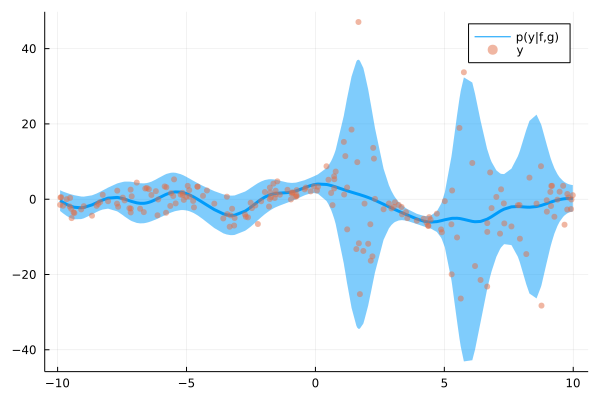

In [4]:
n_sig = 2 # Number of std. dev. around the mean
plot(x, f; ribbon=n_sig * σ, lab="p(y|f,g)") # Mean and std. dev. of y
scatter!(x, y; alpha=0.5, msw=0.0, lab="y") # Observation samples

## Model creation and training
We will now use the augmented model to infer both `f` and `g`

In [5]:
model = VGP(
    x,
    y,
    kernel,
    HeteroscedasticLikelihood(λ),
    AnalyticVI();
    optimiser=true, # We optimise both the mean parameters and kernel hyperparameters
    mean=μ₀,
    verbose=1,
)

Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference 

Model training, we train for around 100 iterations to wait for the convergence of the hyperparameters

In [6]:
train!(model, 100);

[ Info: Starting training Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference  with 200 samples, 1 features and 2 latent GPs
[ Info: Training ended after 100 iterations. Total number of iterations 100


## Predictions
We can now look at the predictions and compare them with out original model

In [7]:
(f_m, g_m), (f_σ, g_σ) = predict_f(model, x_test; cov=true)
y_m, y_σ = proba_y(model, x_test);

Let's first look at the differece between the latent `f` and `g`

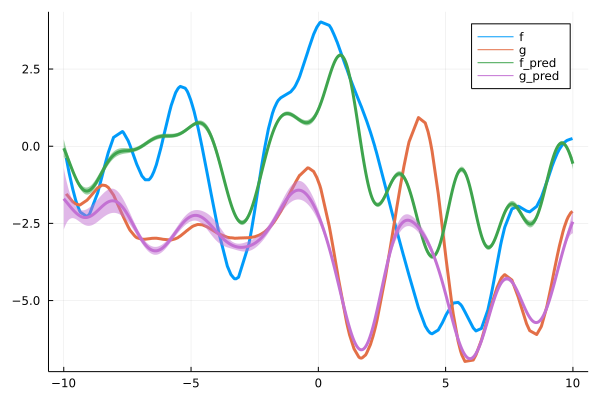

In [8]:
plot(x, [f, g]; label=["f" "g"])
plot!(
    x_test,
    [f_m, g_m];
    ribbon=[n_sig * f_σ n_sig * g_σ],
    lab=["f_pred" "g_pred"],
    legend=true,
)

But it's more interesting to compare the predictive probability of `y` directly:

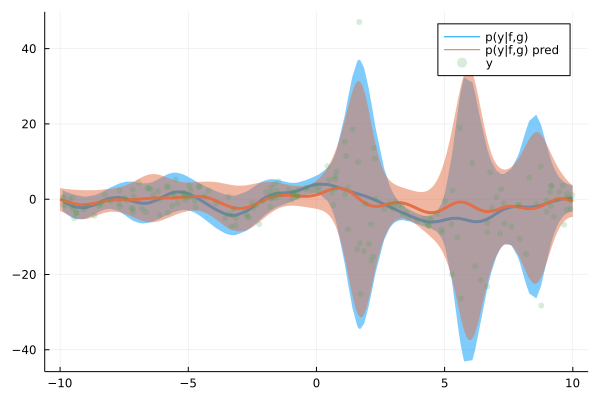

In [9]:
plot(x, f; ribbon=n_sig * σ, lab="p(y|f,g)")
plot!(x_test, y_m; ribbon=n_sig * sqrt.(y_σ), lab="p(y|f,g) pred")
scatter!(x, y; lab="y", alpha=0.2)

Or to explore the heteroscedasticity itself, we can look at the residuals

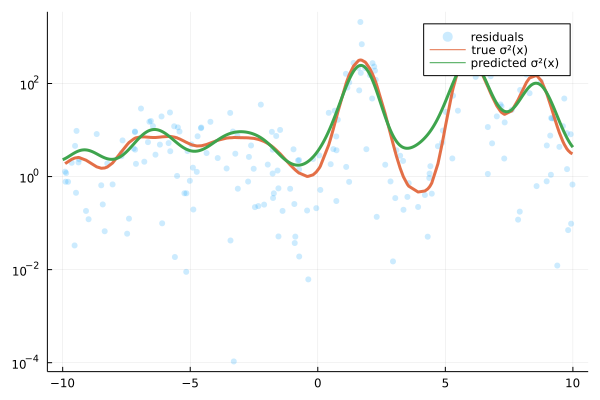

In [10]:
scatter(x, (f - y) .^ 2; yaxis=:log, lab="residuals", alpha=0.2)
plot!(x, σ .^ 2; lab="true σ²(x)")
plot!(x_test, y_σ; lab="predicted σ²(x)")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*